In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from scipy import signal
from tensorflow import keras




2023-11-08 12:38:55.524682: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


2023-11-08 12:38:58.598887: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


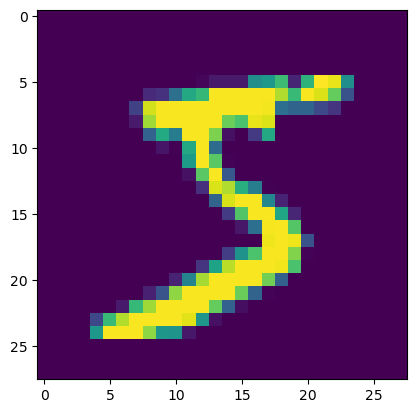

In [3]:
mnist = tf.keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
tf.shape(train_images)

plt.imshow(train_images[0])
plt.show()





In [4]:
model = tf.keras.models.load_model('my_org_model_top4_quant.h5')
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 28, 28, 64)        128       
                                                                 
 activation_8 (Activation)   (None, 28, 28, 64)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 28, 28, 32)        2080      
                                                                 
 activation_9 (Activation)   (None, 28, 28, 32)        0         
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 28, 28, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 28, 28, 16)        528       
                                                      

In [5]:
a = model.get_weights()
a

[array([[[[ 74.,  54., -47.,  79., -74.,  52.,  58.,  -9.,   5.,  -1.,
           -25.,  15., -40.,  -4.,  28.,  18.,  79.,   0., -53.,  17.,
            -8., -71.,  39., -42.,  21.,  -2., -57.,  32.,  20.,   5.,
           -43.,   6.,  59., -46., -53., -35., -39.,  13., -16.,  85.,
           -55., -76.,  68., -65., -30., -43.,  87.,  60.,  52., -67.,
            64., -44., -40., -49.,  87.,  79., -49., -49.,  -4.,  58.,
            46.,  32.,  72.,  82.]]]], dtype=float32),
 array([  1.,  -3.,  -0.,   1.,   0.,  -1.,   0.,   0.,  -5.,   0.,   0.,
         -2.,   0.,   0., -12.,   2.,   1.,   4.,   0.,  -1.,   0.,   0.,
         -2.,   0.,  -8.,   0.,   0.,   1., -15.,  -6.,   0.,  -6.,   1.,
          0.,   0.,   0.,   0., -13.,   0.,   0.,   0.,   0.,   2.,   0.,
          0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,
          1.,   0.,   0.,   0., -17.,   1.,  -7.,   1.,   4.],
       dtype=float32),
 array([[[[ -70.,   41.,  -32., ...,   41., -105.,   63.],
    

In [6]:
extractor_in = keras.Model(inputs=model.inputs,outputs=[layer.input for layer in model.layers])

features_in = extractor_in(test_images)



# Multiplier Exact

In [7]:
Multiplier_Exact = np.zeros([256,256])

for i in range ( -128 , 128) :
  for j in range ( -128 , 128) :
    Multiplier_Exact [ i + 128 , j + 128] = i * j

def My_Mult_Exact (a , b , t =0) :
  a = np.array ( a )
  b = np.array ( b )
  a_shape = np.shape ( a )
  b = np.reshape (b , a_shape )

  res = np . zeros ( a_shape )

  if len ( a_shape ) == 1:
 # E x a c t m u l t i p l i c a t i o n f o r 1 D a r r a y s
    for i in range ( np . shape ( a ) [0]) :
        res [ i ] = Multiplier_Exact [ int ( a [ i ]) + 128 ,
        int ( b [ i ]) + 128]
    if len ( a_shape ) == 2:
 # E x a c t m u l t i p l i c a t i o n f o r 2 D a r r a y s
        for i in range ( a_shape [0]):
            for j in range ( a_shape [1]) :
                res [i , j ] = Multiplier_Exact [ int ( a [i , j
        ]) + 128 , int ( b [i , j ]) + 128]

    return res



In [8]:
def My_Matmul_LT_Exact (a , b , t =0) :
    a = np.array ( a )
    b = np.array ( b )
    a_shape = np.shape ( a )
    b_shape = np.shape ( b )
    res = np.zeros([a_shape[0], b_shape[1]])

    for i in range ( a_shape [0]) :
        for j in range ( b_shape [1]) :
# E x a c t m a t r i x m u l t i p l i c a t i o n u s i n gMy_Mult_Exact
            res [i ,j] = np.sum ( My_Mult_Exact ( a [i , :] , b
            [: , j ] , t ) )

    return res

In [9]:
def My_Conv2d_LT_Exact(a,b,t=0):
    a=np.array(a)
    b=np.array(b)
    a_shape=np.shape(a)
    b_shape=np.shape(b)
    res_shape1=np.abs(a_shape[0]-b_shape[0])+1
    res_shape2=np.abs(a_shape[1]-b_shape[1])+1
    res=np.zeros([res_shape1,res_shape2])
    for i in range(res_shape1):
        for j in range(res_shape2):
            res[i,j]=np.sum(My_Matmul_LT_Exact(np.flip(b),a[i:i+b_shape[0],j:j+b_shape[1]],t))
    return res





# Exact CNN

In [10]:
def Exact_CNN(k ,t):
    # Quantization of input data
    z1 = np.floor(features_in[0][k] / 2)

    z2 = np.zeros([28,28,64])

    # Iterate through the 64 output channels
    for i  in range(64):
        for j in range(1):
            z2[:,:,i]=z2[:,:,i]+My_Conv2d_LT_Exact(np.array(z1[:,:,j]),np.flip(a[0][:,:,j,i]),t)
        z2[:,:,i]=z2[:,:,i]+a[1][i]
    
    # Add biases/weights from the first layer
    z2[:,:,i] = z2[:,:,i] + a[1][i]

    # Apply ReLu Activation Function
    z3 = np.maximum(0,z2)

    # Quantize the feature map 
    z3 = np.round((z3/np.max(z3))*127  )


    z4 = np.zeros([28,28,32])

    for i in range(32):
        for j in range(64):
             z4[:,:,i]=z4[:,:,i]+My_Conv2d_LT_Exact(np.array(z3[:,:,j]),np.flip(a[2][:,:,j,i]),t)
        z4[:,:,i]=z4[:,:,i]+a[3][i]

    # Apply ReLu Activation Function
    z5 = np.maximum(0,z4)

    
    z5 = np.round((z5/ np.max(z5)) * 127)

    z6 = np.zeros([28,28,16])


    for i  in range(16):
        for j in range(32):
            z6[:,:,i]=z6[:,:,i]+My_Conv2d_LT_Exact(np.array(z5[:,:,j]),np.flip(a[4][:,:,j,i]),t)
            z6[:,:,i]=z6[:,:,i]+a[5][i]

    z61 = np.maximum(0,z6)

    z61 = np.round((z61/np.max(z61))* 127)

    z7 = np.zeros([26,26,8])

    for i in range(8):
        for j in range(16):
             z7[:,:,i]=z7[:,:,i]+My_Conv2d_LT_Exact(np.array(z61[:,:,j]),np.flip(a[6][:,:,j,i]),t)
        z7[:,:,i]=z7[:,:,i]+a[7][i]
    z8=np.maximum(0,z7)                # ReLU
    z8=np.round((z8/np.max(z8))*127)   # Quantization
    z9=np.zeros([24,24,4])
    for i in range(4):
        for j in range(8):
             z9[:,:,i]=z9[:,:,i]+My_Conv2d_LT_Exact(np.array(z8[:,:,j]),np.flip(a[8][:,:,j,i]),t)
        z9[:,:,i]=z9[:,:,i]+a[9][i]
        
    z10=np.maximum(0,z9)              # ReLU
    z10=np.round((z10/np.max(z10))*127)  # Quantization
    z13=np.reshape(z10,[1,-1])  #  Flatten layer
    z14=My_Matmul_LT_Exact(z13,a[10],t)+a[11]  
    z15=np.maximum(0,z14) # ReLU
    z15=np.round((z15/np.max(z15))*127)  # Quantization
    z141=My_Matmul_LT_Exact(z15,a[12],t)+a[13] # ReLU
    z151=np.maximum(0,z141)
    z151=np.round((z151/np.max(z151))*127) # Quantization
    z16=My_Matmul_LT_Exact(z151,a[14],t)+a[15]
    z16=np.round((z16/np.max(z16))*127) # Quantization
    return np.argmax(z16), z3,z5,z61,z8,z10,z15,z151,z16



    



    

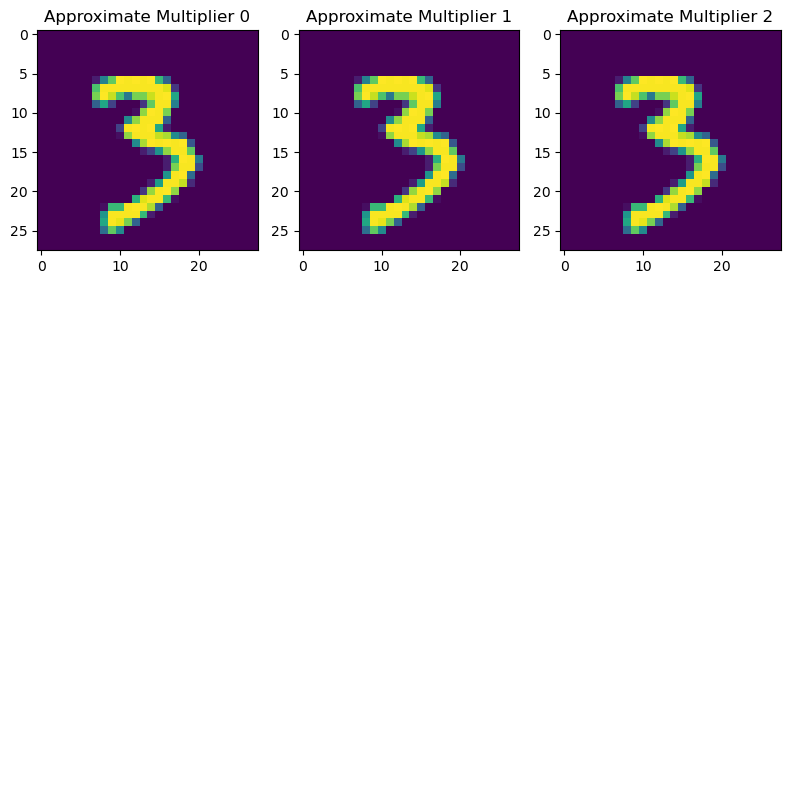

4

In [14]:
Vis_Mat=[]
for i in range(3):
    Vis_Mat.append(Exact_CNN(30,i))

images=[]
Layer_Number=1
for i in range(3):
    images.append(Vis_Mat[i][Layer_Number])

# Create a 3x3 grid of subplots
fig, axes = plt.subplots(3, 3, figsize=(8, 8))

# Loop through your image data and plot each image on a subplot
for i, ax in enumerate(axes.ravel()):
    # Check if there are more images than subplots
    image_data=np.average(images,axis=-1)
    if i < len(image_data):
        ax.imshow(image_data[i])  # Plot the image
        ax.set_title(f'Approximate Multiplier {i}')  # Set a title for the subplot
    else:
        ax.axis('off')  # Turn off the empty subplots if there are fewer images

# Adjust spacing between subplots for better visualization
plt.tight_layout()

# Display the plot
plt.show()

Vis_Mat[0][0]


In [ ]:
# Assuming you have already loaded the model and test data

# Compile the model if it's not already compiled
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(test_images, test_labels)

# Print the test accuracy
print(f'Test accuracy: {test_accuracy}')

313/313 [==============================] - 6s 17ms/step - loss: 56280846826504978432.0000 - accuracy: 0.9925
Test accuracy: 0.9925000071525574


In [ ]:
predictions = model.predict(test_images)

# Find the indices of true "5" labels and predicted "5" labels
true_indices = (test_labels == 6)
predicted_indices = (np.argmax(predictions, axis=1) == 6)

# Create a confusion matrix for the digit "5"
confusion = confusion_matrix(true_indices, predicted_indices)

# Visualize the confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", square=True,
            xticklabels=["Not 5", "Is 5"],
            yticklabels=["Not 5", "Is 5"])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title("Confusion Matrix for Digit '5'")
plt.show()

313/313 [==============================] - 5s 16ms/step


NameError: name 'confusion_matrix' is not defined